Imports for data processing and plotting.

In [1]:
from geopy import distance
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

%matplotlib inline

Load the data from csv.

In [2]:
filepath = 'data/'
collisions = pd.read_csv(filepath + 'Collisions.csv')
signals = pd.read_csv(filepath + "Traffic_Signals.csv")
circles = pd.read_csv(filepath + "Traffic_Circles.csv")

In [3]:
print(collisions.shape)
print(signals.shape)
print(circles.shape)

(203190, 40)
(1107, 62)
(1045, 32)


Filter for NA values and prepare values for plotting.

In [4]:
# Drop NA values

collisions = collisions.dropna(subset=['X', 'Y'])
collisions.shape

circles = circles.dropna(subset=['X', 'Y'])
circles.CONDITION = circles.CONDITION.astype("category")
dict( enumerate(circles.CONDITION.cat.categories) )

{0: ' ', 1: 'FAIR', 2: 'GOOD', 3: 'POOR'}

In [5]:
import plotly.graph_objs as go

mapbox_access_token = "pk.eyJ1IjoiYXVzdGluaHNpZWgiLCJhIjoiY2pwN24ybWdwMXFxNjNzcXI1aTF1a2RhbSJ9.I1pGB8PyJfjjFyM0I4HEnw"

colors = ["Black", "Gold", "Green", "Red"]

data = [
    go.Scattermapbox(
        lat=circles['Y'],
        lon=circles['X'],
        mode='markers',
        text=circles['UNITDESC'].str.strip(),
        hoverinfo='text',
        marker=dict(
            size=6, 
            color = circles['CONDITION'].cat.codes.apply(lambda x: colors[x])
        ),
    )
]

layout = go.Layout(
    title = 'Traffic Circles by Location and Condition',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.607569,
            lon=-122.342064
        ),
        pitch=0,
        zoom=10
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig, filename='Seattle Traffic Circles')

An overview plot of traffic circles in Seattle by condition, with green being good condition, yellow being fair condition, and red being poor condition.

In [9]:
import timestring

data = [
    go.Scattermapbox(
        lat=circles['Y'],
        lon=circles['X'],
        mode='markers',
        text=circles['UNITDESC'].str.strip(),
        hoverinfo='text',
        marker=dict(
            colorbar=dict(
                title='Year Built'
            ),
            size=6, 
            colorscale='Viridis',
            color = pd.to_numeric(pd.to_datetime(circles.INSTALL_DATE.str[:10], format="%Y-%m-%d").dt.year, errors='coerce')
        ),
    )
]

layout = go.Layout(
    title = 'Traffic Circles by Location and Time Built',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.607569,
            lon=-122.342064
        ),
        pitch=0,
        zoom=10
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig, filename='Seattle Traffic Circles')

An overview plot of traffic circles in Seattle by time built.

In [7]:
# Generate new sample, or use saved one.
col = pd.read_csv("collisions_circles_sampled.csv")
# col = collisions.sample(n=2000)

Find the closest traffic circle to each collision (running this will take a while, probably a couple minutes.)

In [17]:
# SKIP THIS IF DATA READ FROM CSV ABOVE #

import scipy

# Generate distances from collision to traffic circle
# mat = scipy.spatial.distance.cdist(col[['Y', 'X']], 
#                               circles[['Y', 'X']], lambda u, v: distance.distance(u, v).kilometers)
# mat

array([[ 2.48561776,  5.15058806,  1.59260153, ...,  5.71881004,
         6.02828209,  2.18339404],
       [10.49452692, 13.39685467,  9.85640328, ..., 13.94302257,
        13.60221098,  8.99173978],
       [ 5.65965857,  2.01732806,  5.76747129, ...,  3.11099902,
         2.98942282,  6.56721775],
       ...,
       [ 7.00706286,  9.45569033,  6.16815691, ..., 10.28834792,
         9.48081285,  4.88853292],
       [ 8.19840378, 10.18544956,  7.25243208, ..., 11.29023624,
         9.7731918 ,  5.42038129],
       [ 6.07623014,  4.68442272,  6.88255711, ...,  2.85360177,
         7.09464954,  8.99877925]])

In [10]:
# SKIP THIS IF DATA READ FROM CSV ABOVE #

# Find the distance to the closest traffic circle for each collision
# mins = mat.min(axis=1)
# minsIndex = np.argmin(mat, axis=1)

# Convert to meters
# col["CLOSEST_CIRCLE_DIST"] = mins * 1000
# col["CLOSEST_CIRCLE_INDEX"] = minsIndex
# col.to_csv("collisions_circles_sampled.csv")

NameError: name 'mat' is not defined

We can filter for accidents that happen within, or very close to a traffic circle by filtering the collisions based on distance. Here I'm restricting the data to collisions within 100m of a traffic circle.

In [23]:
# Filter for accidents inside a traffic circle
close = col[col["CLOSEST_CIRCLE_DIST"] <= 100]
close.shape

(165, 43)

In [31]:
from toolz import interleave

closestCircles = circles.loc[close['CLOSEST_CIRCLE_INDEX'], :]

# Don't include the first column, which just has indices
df = close.drop(close.columns[0], axis=1)

empty = pd.DataFrame(np.nan, index=range(len(df)), columns=df.columns)

inter = pd.DataFrame(interleave([df.values, closestCircles.values, empty.values]))

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-122.312771,47.614499,92323.0,106370.0,106370,3283545,Matched,Intersection,30136,15TH AVE AND E MADISON ST,...,NaN,9181029.0,NaN,28,From opposite direction - one left turn - one ...,0.0,0.0,N,42.956474,79.0
1,-122.312773,47.614113,35.0,509014.0,TRC-188,15TH AVE AND E PIKE ST ...,GOOD,2009-07-06T00:00:00.000Z,INSVC,SDOT,...,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-122.351958,47.692408,30378.0,44611.0,44611,2022919,Matched,Block,NaN,N 87TH ST BETWEEN DAYTON AVE N AND EVANSTON AVE N,...,NaN,5112006.0,NaN,32,One parked--one moving,0.0,0.0,N,49.764350,443.0
4,-122.352621,47.692410,401.0,509653.0,TRC-881,DAYTON AVE N AND N 87TH ST ...,GOOD,2009-09-24T00:00:00.000Z,INSVC,SDOT,...,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-122.314299,47.618788,152649.0,181453.0,181493,3642418,Matched,Intersection,29062,14TH AVE AND E DENNY WAY,...,NaN,NaN,NaN,10,Entering at angle,0.0,0.0,N,98.171941,387.0
7,-122.315604,47.618778,345.0,509106.0,TRC-156,13TH AVE AND E DENNY WAY ...,GOOD,2009-07-06T00:00:00.000Z,INSVC,SDOT,...,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-122.347419,47.661093,173730.0,222656.0,222936,3501779,Matched,Block,NaN,N PHINNEY WAY BETWEEN N 45TH ST AND AURORA AVE N,...,NaN,NaN,NaN,14,From same direction - both going straight - on...,0.0,0.0,N,98.372689,463.0


In [32]:
data = [
    go.Scattermapbox(
        lat=inter[1], # X
        lon=inter[0], # Y
        mode='lines',
        name="Distance from nearest traffic circle",
        opacity = 0.5,
        hoverinfo='text',
        marker=dict(
            size = 4,
            color="Black"
        ),
    ), go.Scattermapbox(
        lat=closestCircles["Y"],
        lon=closestCircles["X"],
        mode='markers',
        name="Traffic Circle",
        opacity = 0.5,
        text=closestCircles['UNITDESC'].str.strip(),
        hoverinfo='text',
        marker=dict(
            size = 8,
            color="Blue"
        ),
    ), go.Scattermapbox(
        lat=close["Y"],
        lon=close["X"],
        mode='markers',
        name="Collision", 
        opacity = 0.5,
        text=close['LOCATION'].str.strip(),
        hoverinfo='text',
        marker=dict(
            size = 7,
            color="Red"
        ),
    )
]

layout = go.Layout(
    title = 'Traffic Collisions',
    width = 1000,
    height = 1000,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.607569,
            lon=-122.342064
        ),
        pitch=0,
        zoom=10.5
    ),
    showlegend=True
)

fig = dict(data=data, layout=layout)

iplot(fig, filename='Seattle Traffic Circles')

We can create a histogram to look at the distribution of collisions by distance to traffic circle.

(array([166., 425., 409., 229., 158.,  99.,  92.,  72.,  53.,  57.,  71.,
         42.,  34.,  25.,  32.,  15.,   6.,   5.,   8.,   2.]),
 array([   0.        ,  100.24090855,  200.4818171 ,  300.72272565,
         400.9636342 ,  501.20454274,  601.44545129,  701.68635984,
         801.92726839,  902.16817694, 1002.40908549, 1102.64999404,
        1202.89090259, 1303.13181114, 1403.37271969, 1503.61362823,
        1603.85453678, 1704.09544533, 1804.33635388, 1904.57726243,
        2004.81817098]),
 <a list of 20 Patch objects>)

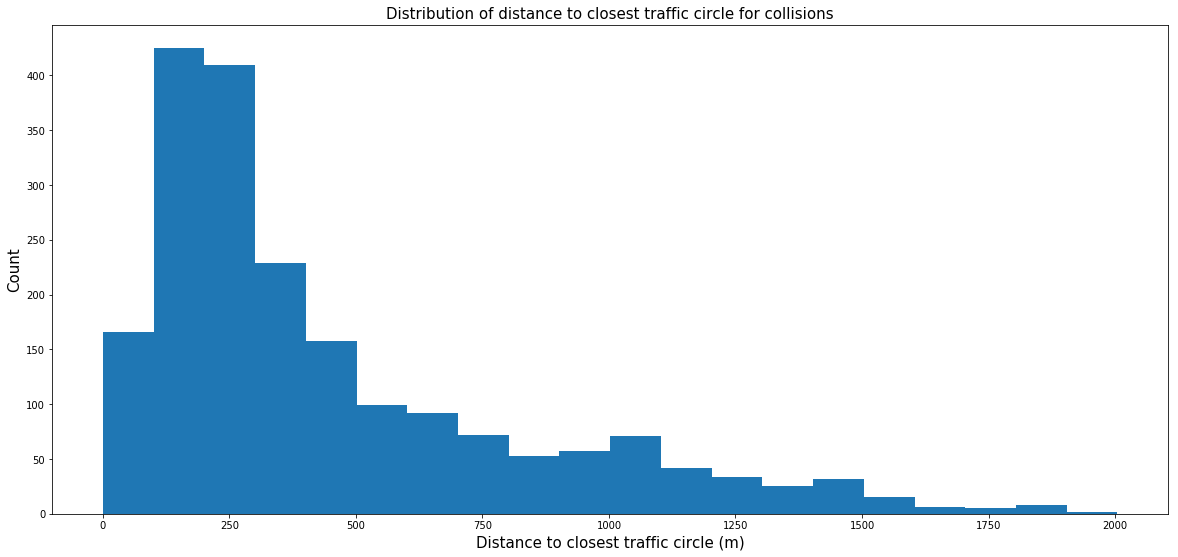

In [14]:
plt.ylabel('Count', fontsize=15)
plt.xlabel('Distance to closest traffic circle (m)', fontsize=15)
plt.title('Distribution of distance to closest traffic circle for collisions', fontsize=15)
plt.hist(col["CLOSEST_CIRCLE_DIST"], bins = 20)

Around 150 out of 2000 collisions (7.5%) occur within 0 to 100m of a traffic circle, but the largest amount of collisions occur within 100 to 300m of a traffic circle.